In [1]:
!pip config set global.index-url https://mirrors.aliyun.com/pypi/simple/
!python -m pip install -U pip
!pip -V
!pip install sklearn pandas

Writing to /root/.config/pip/pip.conf
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.2.4)
pip 20.2.4 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

In [3]:
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.1
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.18.5
pandas 1.1.4
sklearn 0.23.2
tensorflow 2.3.1
tensorflow.keras 2.4.0


In [4]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(len(gpus))

logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(logical_gpus))

1
1


In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_train_all = x_train_all / 255.0
x_test = x_test / 255.0
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28,1 )
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)

In [7]:
def make_dataset(images, labels, epochs, batch_size, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size).prefetch(50)
    return dataset

batch_size_per_replica = 256
batch_size = batch_size_per_replica * len(logical_gpus)
epochs = 100
train_dataset = make_dataset(x_train_scaled, y_train, epochs, batch_size)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [8]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1)))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Execut

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 512)         1

In [10]:
history = model.fit(train_dataset, 
                    steps_per_epoch = x_train_scaled.shape[0] // batch_size,
                    epochs=10)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset 

 57/214 [======>.......................] - ETA: 9s - loss: 2.2818 - accuracy: 0.2002Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


102/214 [=============>................] - ETA: 6s - loss: 2.2447 - accuracy: 0.2793Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


147/214 [===================>..........] - ETA: 3s - loss: 2.0557 - accuracy: 0.3580Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


192/214 [=========================>....] - ETA: 1s - loss: 1.8330 - accuracy: 0.4193Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


214/214 [==============================] - 13s 60ms/step - loss: 1.7390 - accuracy: 0.4445
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device

 57/214 [======>.......................] - ETA: 9s - loss: 0.8904 - accuracy: 0.6752Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


102/214 [=============>................] - ETA: 6s - loss: 0.8534 - accuracy: 0.6886Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


147/214 [===================>..........] - ETA: 4s - loss: 0.8249 - accuracy: 0.7000Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


192/214 [=========================>....] - ETA: 1s - loss: 0.8031 - accuracy: 0.7069Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


214/214 [==============================] - 13s 61ms/step - loss: 0.7929 - accuracy: 0.7099
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job

 59/214 [=======>......................] - ETA: 9s - loss: 0.6958 - accuracy: 0.7411Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


104/214 [=============>................] - ETA: 6s - loss: 0.6754 - accuracy: 0.7495Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


149/214 [===================>..........] - ETA: 3s - loss: 0.6561 - accuracy: 0.7567Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


194/214 [==========================>...] - ETA: 1s - loss: 0.6451 - accuracy: 0.7610Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


214/214 [==============================] - 13s 61ms/step - loss: 0.6394 - accuracy: 0.7618
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job

 61/214 [=======>......................] - ETA: 9s - loss: 0.5783 - accuracy: 0.7836Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


106/214 [=============>................] - ETA: 6s - loss: 0.5693 - accuracy: 0.7902Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


151/214 [====================>.........] - ETA: 3s - loss: 0.5583 - accuracy: 0.7946Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


196/214 [==========================>...] - ETA: 1s - loss: 0.5501 - accuracy: 0.7980Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


214/214 [==============================] - 13s 61ms/step - loss: 0.5463 - accuracy: 0.7991
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job

 63/214 [=======>......................] - ETA: 9s - loss: 0.5095 - accuracy: 0.8083Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


108/214 [==============>...............] - ETA: 6s - loss: 0.5002 - accuracy: 0.8143Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


153/214 [====================>.........] - ETA: 3s - loss: 0.4932 - accuracy: 0.8172Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


198/214 [==========================>...] - ETA: 0s - loss: 0.4877 - accuracy: 0.8190Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


214/214 [==============================] - 13s 61ms/step - loss: 0.4871 - accuracy: 0.8195
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job

 65/214 [========>.....................] - ETA: 8s - loss: 0.4704 - accuracy: 0.8243Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


110/214 [==============>...............] - ETA: 6s - loss: 0.4604 - accuracy: 0.8301Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


155/214 [====================>.........] - ETA: 3s - loss: 0.4536 - accuracy: 0.8336Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


200/214 [===========================>..] - ETA: 0s - loss: 0.4503 - accuracy: 0.8342Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


214/214 [==============================] - 13s 61ms/step - loss: 0.4482 - accuracy: 0.8348
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job

 66/214 [========>.....................] - ETA: 8s - loss: 0.4266 - accuracy: 0.8417Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


111/214 [==============>...............] - ETA: 6s - loss: 0.4221 - accuracy: 0.8436Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


156/214 [====================>.........] - ETA: 3s - loss: 0.4173 - accuracy: 0.8456Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


201/214 [===========================>..] - ETA: 0s - loss: 0.4144 - accuracy: 0.8476Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


214/214 [==============================] - 13s 61ms/step - loss: 0.4147 - accuracy: 0.8469
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job

 67/214 [========>.....................] - ETA: 8s - loss: 0.3987 - accuracy: 0.8525Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


112/214 [==============>...............] - ETA: 6s - loss: 0.3989 - accuracy: 0.8523Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


157/214 [=====================>........] - ETA: 3s - loss: 0.3934 - accuracy: 0.8560Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


202/214 [===========================>..] - ETA: 0s - loss: 0.3929 - accuracy: 0.8561Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


214/214 [==============================] - 13s 61ms/step - loss: 0.3926 - accuracy: 0.8560
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job

 68/214 [========>.....................] - ETA: 8s - loss: 0.3839 - accuracy: 0.8545Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


113/214 [==============>...............] - ETA: 6s - loss: 0.3774 - accuracy: 0.8589Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


158/214 [=====================>........] - ETA: 3s - loss: 0.3720 - accuracy: 0.8619Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


203/214 [===========================>..] - ETA: 0s - loss: 0.3720 - accuracy: 0.8616Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


214/214 [==============================] - 13s 60ms/step - loss: 0.3716 - accuracy: 0.8619
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job

 69/214 [========>.....................] - ETA: 8s - loss: 0.3665 - accuracy: 0.8633Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


114/214 [==============>...............] - ETA: 5s - loss: 0.3599 - accuracy: 0.8674Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


159/214 [=====================>........] - ETA: 3s - loss: 0.3577 - accuracy: 0.8677Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


204/214 [===========================>..] - ETA: 0s - loss: 0.3560 - accuracy: 0.8684Executing op __inference_train_function_921 in device /job:localhost/replica:0/task:0/device:GPU:0


214/214 [==============================] - 13s 60ms/step - loss: 0.3579 - accuracy: 0.8679
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0


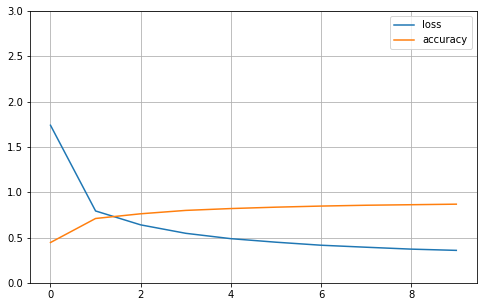

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 3)
    plt.show()
    
plot_learning_curves(history)

In [12]:
model.evaluate(x_test_scaled, y_test)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDatase

Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
 37/313 [==>...........................] - ETA: 4s - loss: 0.3695 - accuracy: 0.8716Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
 41/313 [==>...........................] - ETA: 4s - loss: 0.3734 - accuracy: 0.8697Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5

104/313 [========>.....................] - ETA: 3s - loss: 0.3769 - accuracy: 0.8651Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
108/313 [=========>....................] - ETA: 3s - loss: 0.3735 - accuracy: 0.8663Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
112/313 [=========>....................]

Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
175/313 [===============>..............] - ETA: 2s - loss: 0.3886 - accuracy: 0.8611Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
179/313 [================>.............] - ETA: 2s - loss: 0.3878 - accuracy: 0.8609Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5

Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
243/313 [======================>.......] - ETA: 1s - loss: 0.3747 - accuracy: 0.8642Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
247/313 [======================>.......] - ETA: 1s - loss: 0.3753 - accuracy: 0.8637Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5

Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
311/313 [============================>.] - ETA: 0s - loss: 0.3734 - accuracy: 0.8629Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_5721 in device /job:localhost/replica:0/task:0/device:GPU:0
313/313 [==============================] - 5s 16ms/step - loss: 0.3732 - accuracy: 0.8630
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteMultiDeviceIterator in device /job:localhost/replica:0/task:0/device:CPU:0


[0.37320539355278015, 0.8629999756813049]